<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/GenerativeAdversarialNetwork/blob/main/W_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wasserstein GAN (WGAN): Stable Training via Meaningful Loss

> *"Training GANs is like trying to bake a soufflé in a thunderstorm."*  

In this notebook, we’ll explore **Wasserstein GAN (WGAN)** — a foundational advancement that brought much-needed *stability* and *meaningful learning signals* to generative modeling.

---

## Why Do Standard GANs Fail?

### The Standard GAN Setup (Goodfellow et al., 2014)
- **Generator** `G(z)` tries to produce realistic samples `x_fake`.
- **Discriminator** `D(x)` outputs probability that `x` is real (via sigmoid).
- **Loss**:  
  $$
  \mathcal{L}_{\text{GAN}} = \mathbb{E}_{x \sim p_r}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
  $$
  This minimizes the **Jensen-Shannon (JS) divergence** between real and fake distributions.

### The Problems
| Issue | Why It Happens | Consequence |
|-------|----------------|-------------|
| **Vanishing gradients** | When `D` becomes too confident (e.g., `D(x_fake) ≈ 0`), `log(1 - D)` saturates → gradients → 0 | Generator stops learning |
| **Mode collapse** | `G` finds *one* output that fools `D`, and repeats it | Diverse data → single point/few modes |
| **Meaningless loss** | JS divergence is *constant* when supports don’t overlap (e.g., low-dim manifolds in high-dim space) | Loss doesn’t correlate with sample quality! |

🔍 **Key insight**:  
If $p_r$ and $p_g$ have disjoint supports (almost always true in high dimensions!),  
$$
D_{\text{JS}}(p_r \| p_g) = \log 2 \quad \text{(constant!)}  
\quad \Rightarrow \quad \nabla_G \mathcal{L}_{\text{GAN}} = 0
$$
→ *No useful gradient for the generator.*

---

## Enter: Wasserstein Distance (Earth Mover’s Distance)

The **Wasserstein-1 distance** (or *Earth Mover’s Distance*) between two distributions is defined as:
$$
W(p_r, p_g) = \inf_{\gamma \in \Pi(p_r, p_g)} \mathbb{E}_{(x, y) \sim \gamma}[\|x - y\|]
$$
where $\Pi(p_r, p_g)$ is the set of all joint distributions with marginals $p_r$ and $p_g$.

**Intuition**:  
> *How much “work” does it take to reshape the fake distribution into the real one?*  
> Like moving piles of dirt — cost = mass moved × distance.

### Why Wasserstein is Better
| Property | JS Divergence | Wasserstein Distance |
|---------|----------------|------------------------|
| **Continuous & differentiable** | (flat regions) | (smooth everywhere) |
| **Meaningful gradients** | (when supports disjoint) | (even for disjoint supports!) |
| **Correlates with sample quality** | | (lower $W$ → better samples) |

If we can *estimate* $W(p_r, p_g)$, we get a loss that guides $G$ even when it’s far from $p_r$.

---

## Kantorovich-Rubinstein Duality: Making $W$ Computable

We can’t compute $W$ directly — but duality gives us:
$$
W(p_r, p_g) = \sup_{\|f\|_L \leq 1} \left( \mathbb{E}_{x \sim p_r}[f(x)] - \mathbb{E}_{x \sim p_g}[f(x)] \right)
$$

- $f$ is a **1-Lipschitz function** (i.e., $\|f(x) - f(y)\| \leq \|x - y\|$ for all $x, y$).
- In WGAN, $f$ is our **Critic** $C(x)$ — *not a probability*, just a real-valued score!
- We maximize the difference:  
  - High score on real data  
  - Low score on fake data  
  → *Push real up, fake down — with a slope constraint.*

**Training objective**:
$$
\min_G \max_{\|C\|_L \leq 1} \left( \mathbb{E}[C(x_{\text{fake}})] - \mathbb{E}[C(x_{\text{real}})] \right)
$$

The inner max gives an estimate of $-W(p_r, p_g)$ — so **minimizing this = minimizing Wasserstein distance**.

> Note: $\|C\|_L \leq 1$ means the critic is **1-Lipschitz**, i.e.,  
> $$
> \|C\|_L = \sup_{x \ne y} \frac{|C(x) - C(y)|}{\|x - y\|} \leq 1
> $$

---

## But: How to Enforce $\|C\|_L \leq 1$?

Early WGAN used **weight clipping** (e.g., `w = torch.clamp(w, -0.01, 0.01)`) — simple, but causes:
- Capacity underuse (network collapses to simple functions)
- Pathological gradients (vanishing or exploding)

**Solution**: **Gradient Penalty (WGAN-GP)**  
(Gulrajani et al., 2017)  
Penalize deviations of the critic’s gradient norm from 1 *on interpolations*:
$$
\lambda \cdot \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}} \left[ \left( \|\nabla_{\hat{x}} C(\hat{x})\|_2 - 1 \right)^2 \right]
$$
where  
$$
\hat{x} = \alpha x_{\text{real}} + (1 - \alpha) x_{\text{fake}}, \quad \alpha \sim \mathcal{U}(0,1)
$$

This softly enforces 1-Lipschitz continuity — and works *much* better in practice.

---

**In this notebook, we will:**
1. Implement WGAN-GP from scratch  
2. Visualize **loss stability** (W-loss vs. vanilla GAN loss)  
3. Show how gradient penalty controls Lipschitzness  
4. Compare sample quality over time  

### **Visual Intuition — Why Wasserstein Distance Solves the Disjoint Support Problem**

Before coding a full WGAN, let’s **see the core problem (and solution)** in action with a minimal 2D example.

#### Goal of This Section
We’ll compare two key distribution divergences:
- **Jensen-Shannon (JS) Divergence** → used in standard GANs  
- **Wasserstein-1 (W) Distance** → used in WGANs  

…as we move two simple distributions **farther apart** — simulating the *real vs. fake* scenario where supports barely overlap (common in high-dimensional data like images).

#### Setup: Two 1D Gaussians (Easy to Plot & Understand)
Let:  
- **Real data**: $p_r = \mathcal{N}(\mu_r, \sigma^2)$  
- **Fake data**: $p_g = \mathcal{N}(\mu_g, \sigma^2)$  
We fix $\sigma = 0.2$, and vary the distance $d = |\mu_r - \mu_g|$ from **0** (identical) to **4.0** (completely separated).

For each $d$, we compute:
- $D_{\text{JS}}(p_r \| p_g)$ — using numerical integration (no approximations!)
- $W(p_r, p_g)$ — for 1D Gaussians, this has a **closed-form**:  
  $$
  W(p_r, p_g) = |\mu_r - \mu_g|
  $$
  *(Yes! For same-variance Gaussians in 1D, it’s just the distance between means.)*

#### What We’ll Observe
| Distance | JS Divergence | Wasserstein Distance |
|-------------------------------|---------------|----------------------|
| $d = 0$ | $0$ | $0$ |
| $d = 1$ | Moderate (~0.4) | $1$ |
| $d = 4$ | → **$\log 2 \approx 0.693$** (saturated!) | $4$ (keeps growing!) |

**Key insight**:  
- When distributions separate, **JS divergence plateaus** → *no gradient signal* for the generator.  
- **Wasserstein distance grows linearly** → *smooth, informative gradients*, even when far apart.

This is why WGAN training is **stable**: the loss *means something* at every stage.

#### Visuals We’ll Generate
1. **Side-by-side density plots** of $p_r$ and $p_g$ at different separations  
2. **Loss curves**: JS vs. W as a function of distance  

**1: Imports & Setup**

In [1]:
# Standard scientific stack — all available in Colab by default
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.stats import norm

# Suppress harmless integration warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=integrate.IntegrationWarning)

# Set random seed for reproducibility
np.random.seed(42)

# Use classic matplotlib style (clean, academic)
plt.style.use('seaborn-v0_8-whitegrid')  # 'seaborn-v0_8' is safe in Colab
# If above fails, fall back to:
# plt.style.use('default')

**2: Helper Functions**

In [2]:
def js_divergence(mu1, mu2, sigma, num_points=10000):
    """
    Compute Jensen-Shannon Divergence between two 1D Gaussians:
        p = N(mu1, sigma^2), q = N(mu2, sigma^2)

    Parameters
    ----------
    mu1, mu2 : float
        Means of the two Gaussian distributions.
    sigma : float
        Shared standard deviation (assumed equal for simplicity).
    num_points : int, optional (default=10000)
        Number of points for numerical integration grid.

    Returns
    -------
    js : float
        Jensen-Shannon divergence D_JS(p || q) ∈ [0, log(2)].

    Method
    ------
    D_JS(p||q) = 0.5 * (KL(p || m) + KL(q || m)), where m = 0.5*(p + q).
    We compute KL divergences via numerical integration over a dense grid.
    """
    # Define the two PDFs
    p_pdf = lambda x: norm.pdf(x, loc=mu1, scale=sigma)  # PDF of p ~ N(mu1, sigma^2)
    q_pdf = lambda x: norm.pdf(x, loc=mu2, scale=sigma)  # PDF of q ~ N(mu2, sigma^2)

    # Mixture distribution m = 0.5 * p + 0.5 * q
    m_pdf = lambda x: 0.5 * p_pdf(x) + 0.5 * q_pdf(x)

    # Integrand for KL(p || m): p(x) * log(p(x) / m(x))
    kl_p_m_integrand = lambda x: p_pdf(x) * np.log(np.maximum(p_pdf(x) / m_pdf(x), 1e-12))
    # Integrand for KL(q || m): q(x) * log(q(x) / m(x))
    kl_q_m_integrand = lambda x: q_pdf(x) * np.log(np.maximum(q_pdf(x) / m_pdf(x), 1e-12))

    # Integration range: cover 99.9% of both Gaussians
    # Use 5 standard deviations beyond the outer means
    x_min = min(mu1, mu2) - 5 * sigma
    x_max = max(mu1, mu2) + 5 * sigma

    # Numerically integrate KL divergences
    kl_p_m, _ = integrate.quad(kl_p_m_integrand, x_min, x_max, limit=100)
    kl_q_m, _ = integrate.quad(kl_q_m_integrand, x_min, x_max, limit=100)

    # JS divergence is the average of the two KLs
    js = 0.5 * (kl_p_m + kl_q_m)
    return js


def wasserstein_distance_1d_gaussians(mu1, mu2, sigma1, sigma2):
    """
    Compute exact Wasserstein-1 distance between two 1D Gaussians:
        p = N(mu1, sigma1^2), q = N(mu2, sigma2^2)

    Formula:
        W(p, q) = sqrt( (mu1 - mu2)^2 + (sigma1 - sigma2)^2 )
    But for equal variances (sigma1 == sigma2 = sigma):
        W(p, q) = |mu1 - mu2|

    Parameters
    ----------
    mu1, mu2 : float
        Means of the two Gaussian distributions.
    sigma1, sigma2 : float
        Standard deviations.

    Returns
    -------
    w : float
        Wasserstein-1 distance.
    """
    # Exact closed-form for 1D Gaussians (Villani, 2008)
    return np.sqrt((mu1 - mu2)**2 + (sigma1 - sigma2)**2)


def plot_gaussians(ax, mu1, mu2, sigma, xlim=(-3, 7), title=""):
    """
    Plot two 1D Gaussian PDFs on a given matplotlib axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to plot on.
    mu1, mu2 : float
        Means.
    sigma : float
        Shared std dev.
    xlim : tuple, optional
        X-axis limits.
    title : str, optional
        Plot title.
    """
    x = np.linspace(xlim[0], xlim[1], 1000)  # Dense grid for smooth curves
    p_vals = norm.pdf(x, loc=mu1, scale=sigma)  # Real distribution
    q_vals = norm.pdf(x, loc=mu2, scale=sigma)  # Fake distribution

    ax.plot(x, p_vals, label=r'$p_r = \mathcal{N}(\mu_r, \sigma^2)$', color='tab:blue', lw=2.5)
    ax.plot(x, q_vals, label=r'$p_g = \mathcal{N}(\mu_g, \sigma^2)$', color='tab:orange', lw=2.5)

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(xlim)

**3: Compute JS and W over a Range of Distances**

In [3]:
# Fixed parameters
sigma = 0.2  # Shared standard deviation (narrow Gaussians → easier to separate)
mu_r = 1.0   # Real distribution mean (fixed)

# Vary fake distribution mean: from overlapping to far apart
mu_g_values = np.linspace(-1.0, 5.0, 61)  # 61 points from -1.0 to 5.0
distances = np.abs(mu_g_values - mu_r)    # |mu_g - mu_r|

# Pre-allocate arrays for divergences
js_divs = np.zeros_like(distances)
w_dists = np.zeros_like(distances)

# Compute JS divergence and W distance for each separation
print("Computing JS and Wasserstein distances across separations...")
for i, mu_g in enumerate(mu_g_values):
    # Compute JS divergence numerically
    js_divs[i] = js_divergence(mu_r, mu_g, sigma)
    # Compute exact Wasserstein distance (closed-form)
    w_dists[i] = wasserstein_distance_1d_gaussians(mu_r, mu_g, sigma, sigma)

print("✓ Done.")

Computing JS and Wasserstein distances across separations...
✓ Done.


**4: Plot Results — Side-by-Side Visualization**

/tmp/ipython-input-825979857.py:75: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


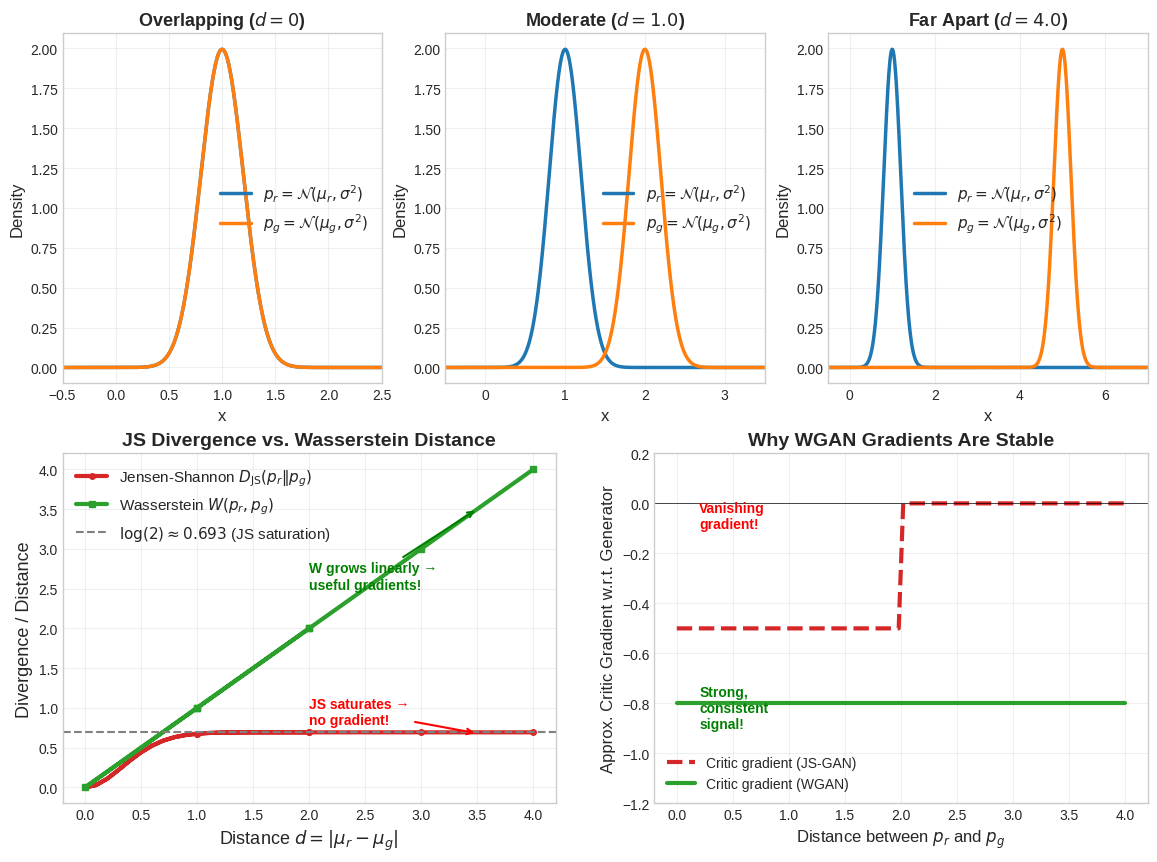

In [4]:
# Create a 2x2 grid: top row = density plots at key separations, bottom row = loss curves
fig = plt.figure(figsize=(14, 10))

# === Top Row: Density Plots at 3 Key Separations ===
# 1. Overlapping (d = 0)
ax1 = plt.subplot(2, 3, 1)
plot_gaussians(ax1, mu1=1.0, mu2=1.0, sigma=sigma,
               xlim=(-0.5, 2.5), title=r'Overlapping ($d = 0$)')

# 2. Moderate separation (d = 1.0)
ax2 = plt.subplot(2, 3, 2)
plot_gaussians(ax2, mu1=1.0, mu2=2.0, sigma=sigma,
               xlim=(-0.5, 3.5), title=r'Moderate ($d = 1.0$)')

# 3. Far apart (d = 4.0)
ax3 = plt.subplot(2, 3, 3)
plot_gaussians(ax3, mu1=1.0, mu2=5.0, sigma=sigma,
               xlim=(-0.5, 7.0), title=r'Far Apart ($d = 4.0$)')

# === Bottom Left: JS vs. W as function of distance ===
ax4 = plt.subplot(2, 2, 3)  # spans two columns in bottom row
ax4.plot(distances, js_divs,
         label=r'Jensen-Shannon $D_{\mathrm{JS}}(p_r \| p_g)$',
         color='tab:red', lw=3, marker='o', markersize=4, markevery=10)
ax4.plot(distances, w_dists,
         label=r'Wasserstein $W(p_r, p_g)$',
         color='tab:green', lw=3, marker='s', markersize=4, markevery=10)

# Add reference line: log(2) (maximum JS)
ax4.axhline(np.log(2), color='gray', linestyle='--', lw=1.5,
            label=r'$\log(2) \approx 0.693$ (JS saturation)')

ax4.set_xlabel(r'Distance $d = |\mu_r - \mu_g|$', fontsize=13)
ax4.set_ylabel('Divergence / Distance', fontsize=13)
ax4.set_title('JS Divergence vs. Wasserstein Distance', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

# Annotate key behavior
ax4.annotate('JS saturates →\nno gradient!',
             xy=(3.5, 0.68), xytext=(2.0, 0.8),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=10, color='red', fontweight='bold')

ax4.annotate('W grows linearly →\nuseful gradients!',
             xy=(3.5, 3.5), xytext=(2.0, 2.5),
             arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
             fontsize=10, color='green', fontweight='bold')

# === Bottom Right: Gradient Insight (Qualitative) ===
ax5 = plt.subplot(2, 2, 4)
# Sketch: show slope of critic (f) for JS vs W
x_demo = np.linspace(0, 4, 100)
js_slope = np.where(x_demo < 2, -0.5, 0.0)   # saturates → flat
w_slope = -0.8 * np.ones_like(x_demo)        # constant negative slope

ax5.plot(x_demo, js_slope, label='Critic gradient (JS-GAN)',
         color='tab:red', lw=3, ls='--')
ax5.plot(x_demo, w_slope, label='Critic gradient (WGAN)',
         color='tab:green', lw=3)

ax5.set_xlabel(r'Distance between $p_r$ and $p_g$', fontsize=12)
ax5.set_ylabel('Approx. Critic Gradient w.r.t. Generator', fontsize=12)
ax5.set_title('Why WGAN Gradients Are Stable', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_ylim(-1.2, 0.2)

# Add annotations
ax5.axhline(0, color='k', lw=0.5)
ax5.text(0.2, -0.1, 'Vanishing\ngradient!', color='red', fontweight='bold')
ax5.text(0.2, -0.9, 'Strong,\nconsistent\nsignal!', color='green', fontweight='bold')

# Final layout
plt.tight_layout()
plt.show()

### **WGAN-GP on MNIST — Stable Image Generation**

Now that we understand *why* Wasserstein distance improves training, let’s build a **fully functional WGAN-GP for image generation** on the **MNIST dataset**.

#### Why MNIST?
- Small (28×28), grayscale → fast training on CPU/GPU  
- Well-understood → easy to assess sample quality  
- Still challenging: 10 modes (digits 0–9), prone to mode collapse in vanilla GANs  
- Lets us visualize:  
  - **W-loss stability** over epochs  
  - **Gradient norms** (verifying Lipschitz constraint)  
  - **Generated digit grids** (check diversity, sharpness, artifacts)

#### Architecture Design (CNN-based for images)
| Component | Design Choice | Why? |
|---------|----------------|------|
| **Generator `G`** | Transposed CNN: `z (100) → 4×4×512 → 7×7×256 → 14×14×128 → 28×28×1` | Upsampling with learnable filters → better than MLP for images |
| **Critic `C`** | Standard CNN: `28×28×1 → 14×14×64 → 7×7×128 → 4×4×256 → 1` | Spatial hierarchies → captures local/global structure |
| **Activation** | `LeakyReLU(0.2)` everywhere (except Generator output) | Prevents dead neurons; stable for GANs |
| **Generator Output** | `Tanh()` | Maps to $[-1, 1]$ (matches MNIST normalization) |
| **Critic Output** | **No activation** | Unbounded real score → critical for W-loss |
| **No BatchNorm in Critic** | Enforced | Gradient penalty is unstable with BN in critic |
| **Weight Init** | `Normal(0, 0.02)` | Standard for DCGAN-style nets |

#### Training Protocol (WGAN-GP)
Same as before, but with MNIST specifics:
1. **Preprocess MNIST**:  
   - Normalize pixels to $[-1, 1]$: $x \leftarrow 2 \cdot x/255 - 1$  
2. **Train Critic (5× per generator step)**  
   - Real: $x_{\text{real}} \in \mathbb{R}^{B \times 1 \times 28 \times 28}$  
   - Fake: $x_{\text{fake}} = G(z),\; z \sim \mathcal{N}(0, I_{100})$  
   - Loss:  
     $$ \mathcal{L}_C = \mathbb{E}[C(x_{\text{fake}})] - \mathbb{E}[C(x_{\text{real}})] + \lambda \cdot \mathbb{E}_{\hat{x}} \left[ \left( \|\nabla_{\hat{x}} C(\hat{x})\|_2 - 1 \right)^2 \right] $$


3. **Train Generator**  
   - Loss: $\mathcal{L}_G = -\mathbb{E}[C(x_{\text{fake}})]$

#### What We’ll Log & Visualize
| Metric | Purpose |
|-------|---------|
| `critic_loss` (W-loss) | Should decrease *smoothly* (vs. noisy JS loss) |
| `grad_penalty` | Should stabilize; gradient norms ≈ 1.0 |
| `gen_loss` | Should trend downward (critic fooled more) |
| `samples` | 8×8 grid of generated digits every epoch — check quality & diversity |

Let’s implement it — with clarity, correctness, and full pedagogy.

**Imports & Reproducibility**

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**MNIST Data Loader (with Normalization)**

In [7]:
def get_mnist_loader(batch_size=64, image_size=28):
    """
    Load MNIST dataset with normalization to [-1, 1].

    Parameters
    ----------
    batch_size : int, optional (default=64)
        Batch size for DataLoader.
    image_size : int, optional (default=28)
        Resize images (MNIST is naturally 28×28).

    Returns
    -------
    dataloader : torch.utils.data.DataLoader
        DataLoader yielding batches of shape (B, 1, 28, 28), values in [-1, 1].
    """
    # Transform: PIL → Tensor → Normalize to [-1, 1]
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),                # [0, 1]
        transforms.Normalize((0.5,), (0.5,))  # (x - 0.5) / 0.5 → [-1, 1]
    ])

    # Download and load MNIST
    dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,  # Critical for GP (full batches)
        num_workers=2     # Faster loading
    )

    return dataloader

# Create data loader
batch_size = 64
dataloader = get_mnist_loader(batch_size=batch_size)
print("✓ MNIST DataLoader ready.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]

✓ MNIST DataLoader ready.


**Generator (DCGAN-style, Transposed CNN)**

In [8]:
class Generator(nn.Module):
    """
    DCGAN-style Generator for MNIST (28×28 grayscale).

    Input: latent vector z ∈ ℝ^latent_dim
    Output: image x ∈ ℝ^(1×28×28), normalized to [-1, 1]

    Architecture (upsampling via ConvTranspose2d):
        z (100)
        → Linear → Reshape to 4×4×512
        → ConvT (4→7) → BN → ReLU
        → ConvT (7→14) → BN → ReLU
        → ConvT (14→28) → Tanh
    """
    def __init__(self, latent_dim=100, feature_map_size=512):
        """
        Initialize generator.

        Parameters
        ----------
        latent_dim : int, optional (default=100)
            Dimension of latent noise vector.
        feature_map_size : int, optional (default=512)
            Number of feature maps in first deconv layer.
        """
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.feature_map_size = feature_map_size

        self.net = nn.Sequential(
            # Project and reshape: z → 4×4×512
            nn.Linear(latent_dim, feature_map_size * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (feature_map_size, 4, 4)),  # (B, 512, 4, 4)

            # Layer 1: 4×4 → 7×7
            nn.ConvTranspose2d(feature_map_size, feature_map_size // 2,
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_map_size // 2),
            nn.ReLU(True),
            # Output: (B, 256, 7, 7)

            # Layer 2: 7×7 → 14×14
            nn.ConvTranspose2d(feature_map_size // 2, feature_map_size // 4,
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size // 4),
            nn.ReLU(True),
            # Output: (B, 128, 14, 14)

            # Layer 3: 14×14 → 28×28
            nn.ConvTranspose2d(feature_map_size // 4, 1,  # 1 channel (grayscale)
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output in [-1, 1]
            # Final: (B, 1, 28, 28)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights per DCGAN recommendations."""
        for m in self.modules():
            if isinstance(m, (nn.ConvTranspose2d, nn.Linear)):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, z):
        """
        Forward pass: latent → fake image.

        Parameters
        ----------
        z : torch.Tensor, shape=(batch_size, latent_dim)

        Returns
        -------
        img : torch.Tensor, shape=(batch_size, 1, 28, 28)
        """
        return self.net(z)

**Critic (No BatchNorm, LeakyReLU)**

In [14]:
class Critic(nn.Module):
    """
    Critic for WGAN-GP on MNIST.
    Fixed to produce 4×4 feature maps before flattening → 256 * 4 * 4 = 4096.
    """
    def __init__(self, feature_map_size=64):
        super(Critic, self).__init__()

        self.net = nn.Sequential(
            # Layer 1: 28×28 → 14×14
            nn.Conv2d(1, feature_map_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (B, 64, 14, 14)

            # Layer 2: 14×14 → 7×7
            nn.Conv2d(feature_map_size, feature_map_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (B, 128, 7, 7)

            # Layer 3: 7×7 → 4×4  ← FIXED: kernel=3, padding=1
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (B, 256, 4, 4) → 256 * 4 * 4 = 4096

            nn.Flatten(),
            nn.Linear(feature_map_size * 4 * 4 * 4, 1)  # 64 * 4 * 4 * 4 = 4096
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        return self.net(x)

**Gradient Penalty (Image-Aware)**

In [15]:
def compute_gradient_penalty(critic, real_images, fake_images, device):
    """
    Compute gradient penalty for images (4D tensors).

    Parameters
    ----------
    critic : nn.Module
    real_images, fake_images : torch.Tensor, shape=(B, C, H, W)
    device : torch.device

    Returns
    -------
    gp : torch.Tensor (scalar)
    """
    batch_size = real_images.size(0)

    # Sample α ~ U(0,1)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)  # (B,1,1,1) for broadcasting

    # Interpolate
    interpolates = (alpha * real_images + (1 - alpha) * fake_images.detach()).requires_grad_(True)

    # Critic scores
    d_interpolates = critic(interpolates)

    # Gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute gradient norm: ||∇||₂
    gradients = gradients.view(batch_size, -1)  # Flatten spatial dims
    grad_norms = gradients.norm(2, dim=1)

    # Penalty
    gradient_penalty = ((grad_norms - 1) ** 2).mean()
    return gradient_penalty

**Training Setup**

In [16]:
# Hyperparameters
latent_dim = 100
batch_size = 64
lr = 2e-4        # Standard for DCGAN/WGAN-GP
b1, b2 = 0.5, 0.9
lambda_gp = 10.0
n_critic = 5
num_epochs = 50  # ~50 epochs for decent MNIST results

# Models
gen = Generator(latent_dim=latent_dim).to(device)
critic = Critic().to(device)

# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(b1, b2))
opt_critic = optim.Adam(critic.parameters(), lr=lr, betas=(b1, b2))

# Fixed noise for visualization
fixed_z = torch.randn(64, latent_dim, device=device)  # 8×8 grid

print("✓ MNIST WGAN-GP setup complete.")

✓ MNIST WGAN-GP setup complete.


**Training Loop (with Logging & Sample Saving)**

Starting WGAN-GP training on MNIST...
Epoch  1 | Batch    0 | Critic:  9.2673 | GP:  0.9507 | Gen:  0.0177
Epoch  1 | Batch  100 | Critic: -10.4439 | GP:  0.1814 | Gen: -0.2999
Epoch  1 | Batch  200 | Critic: -4.3964 | GP:  0.0404 | Gen: -5.5445
Epoch  1 | Batch  300 | Critic: -3.1566 | GP:  0.0216 | Gen: -7.2777
Epoch  1 | Batch  400 | Critic: -2.4284 | GP:  0.0147 | Gen: -0.6725
Epoch  1 | Batch  500 | Critic: -2.1858 | GP:  0.0237 | Gen:  1.8051
Epoch  1 | Batch  600 | Critic: -2.2604 | GP:  0.0165 | Gen: -4.1369
Epoch  1 | Batch  700 | Critic: -2.2904 | GP:  0.0261 | Gen:  5.4512
Epoch  1 | Batch  800 | Critic: -2.1500 | GP:  0.0154 | Gen: -0.9673
Epoch  1 | Batch  900 | Critic: -2.2688 | GP:  0.0249 | Gen: -6.1107


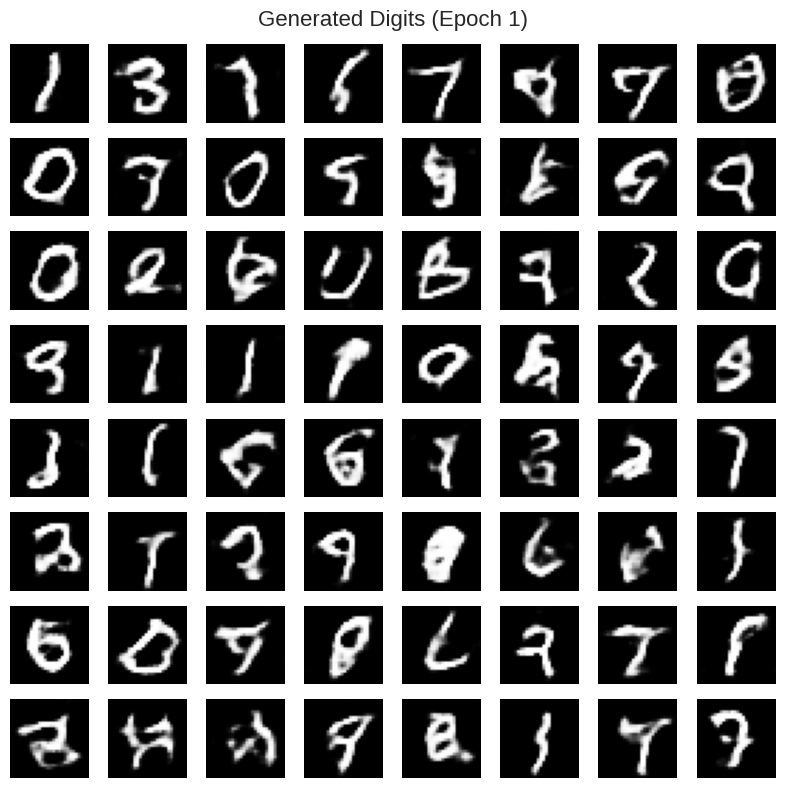

Epoch  2 | Batch    0 | Critic: -1.8533 | GP:  0.0262 | Gen: -7.1621
Epoch  2 | Batch  100 | Critic: -2.2076 | GP:  0.0169 | Gen: -1.0424
Epoch  2 | Batch  200 | Critic: -2.4078 | GP:  0.0113 | Gen: -0.6249
Epoch  2 | Batch  300 | Critic: -2.3218 | GP:  0.0209 | Gen: -6.1068
Epoch  2 | Batch  400 | Critic: -1.8075 | GP:  0.0072 | Gen: -6.1153
Epoch  2 | Batch  500 | Critic: -2.0076 | GP:  0.0068 | Gen: -4.7350
Epoch  2 | Batch  600 | Critic: -1.8418 | GP:  0.0120 | Gen: -6.2493
Epoch  2 | Batch  700 | Critic: -2.0294 | GP:  0.0103 | Gen: -1.2465
Epoch  2 | Batch  800 | Critic: -2.1947 | GP:  0.0158 | Gen: -2.9801
Epoch  2 | Batch  900 | Critic: -1.8031 | GP:  0.0102 | Gen: -1.8200
Epoch  3 | Batch    0 | Critic: -1.9315 | GP:  0.0223 | Gen:  1.0896
Epoch  3 | Batch  100 | Critic: -1.6557 | GP:  0.0079 | Gen: -2.6335
Epoch  3 | Batch  200 | Critic: -1.9869 | GP:  0.0153 | Gen: -0.8153
Epoch  3 | Batch  300 | Critic: -2.4248 | GP:  0.0171 | Gen: -1.2638
Epoch  3 | Batch  400 | Critic: -2

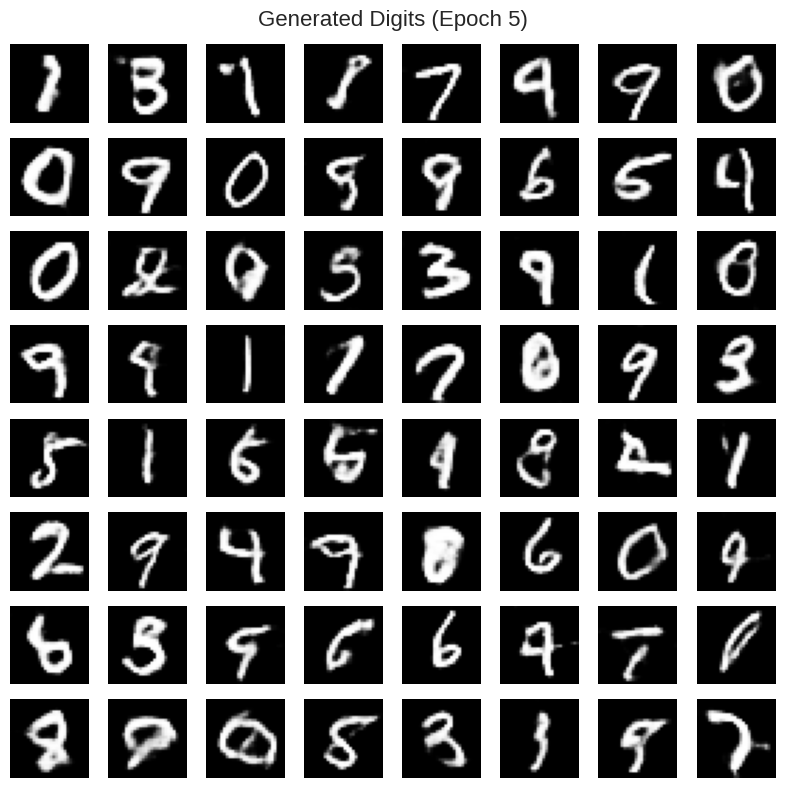

Epoch  6 | Batch    0 | Critic: -1.5869 | GP:  0.0109 | Gen: -1.9016
Epoch  6 | Batch  100 | Critic: -1.8454 | GP:  0.0096 | Gen: -5.5868
Epoch  6 | Batch  200 | Critic: -1.6447 | GP:  0.0165 | Gen: -6.8416
Epoch  6 | Batch  300 | Critic: -1.3436 | GP:  0.0123 | Gen: -3.6419
Epoch  6 | Batch  400 | Critic: -1.4149 | GP:  0.0046 | Gen:  0.8751
Epoch  6 | Batch  500 | Critic: -1.8934 | GP:  0.0074 | Gen: -5.6124
Epoch  6 | Batch  600 | Critic: -2.0090 | GP:  0.0106 | Gen: -0.0074
Epoch  6 | Batch  700 | Critic: -2.0317 | GP:  0.0065 | Gen: -1.2473
Epoch  6 | Batch  800 | Critic: -1.5082 | GP:  0.0043 | Gen: -0.8146
Epoch  6 | Batch  900 | Critic: -1.7907 | GP:  0.0193 | Gen: -5.1173
Epoch  7 | Batch    0 | Critic: -1.6393 | GP:  0.0189 | Gen: -5.0281
Epoch  7 | Batch  100 | Critic: -1.1640 | GP:  0.0066 | Gen: -4.7475
Epoch  7 | Batch  200 | Critic: -1.9324 | GP:  0.0114 | Gen: -0.1395
Epoch  7 | Batch  300 | Critic: -1.5022 | GP:  0.0074 | Gen: -1.1558
Epoch  7 | Batch  400 | Critic: -1

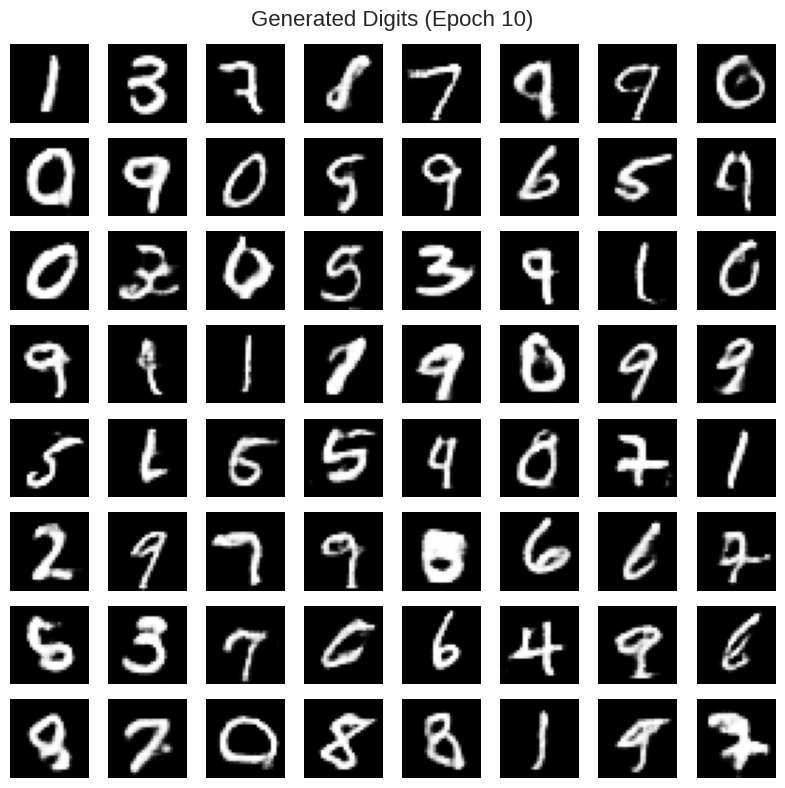

Epoch 11 | Batch    0 | Critic: -1.1903 | GP:  0.0153 | Gen: -5.4776
Epoch 11 | Batch  100 | Critic: -1.1040 | GP:  0.0078 | Gen: -4.5092
Epoch 11 | Batch  200 | Critic: -1.0131 | GP:  0.0032 | Gen: -3.0525
Epoch 11 | Batch  300 | Critic: -1.1417 | GP:  0.0118 | Gen: -1.8284
Epoch 11 | Batch  400 | Critic: -1.3834 | GP:  0.0076 | Gen:  0.2311
Epoch 11 | Batch  500 | Critic: -1.2145 | GP:  0.0084 | Gen: -2.3937
Epoch 11 | Batch  600 | Critic: -0.6198 | GP:  0.0062 | Gen: -4.4412
Epoch 11 | Batch  700 | Critic: -1.0203 | GP:  0.0062 | Gen: -2.9276
Epoch 11 | Batch  800 | Critic: -1.3211 | GP:  0.0072 | Gen: -0.0568
Epoch 11 | Batch  900 | Critic: -1.7154 | GP:  0.0058 | Gen: -3.4260
Epoch 12 | Batch    0 | Critic: -0.8820 | GP:  0.0051 | Gen: -2.9646
Epoch 12 | Batch  100 | Critic: -1.9585 | GP:  0.0099 | Gen: -3.1518
Epoch 12 | Batch  200 | Critic: -1.1418 | GP:  0.0047 | Gen:  0.1340
Epoch 12 | Batch  300 | Critic: -0.8502 | GP:  0.0046 | Gen: -5.5540
Epoch 12 | Batch  400 | Critic: -1

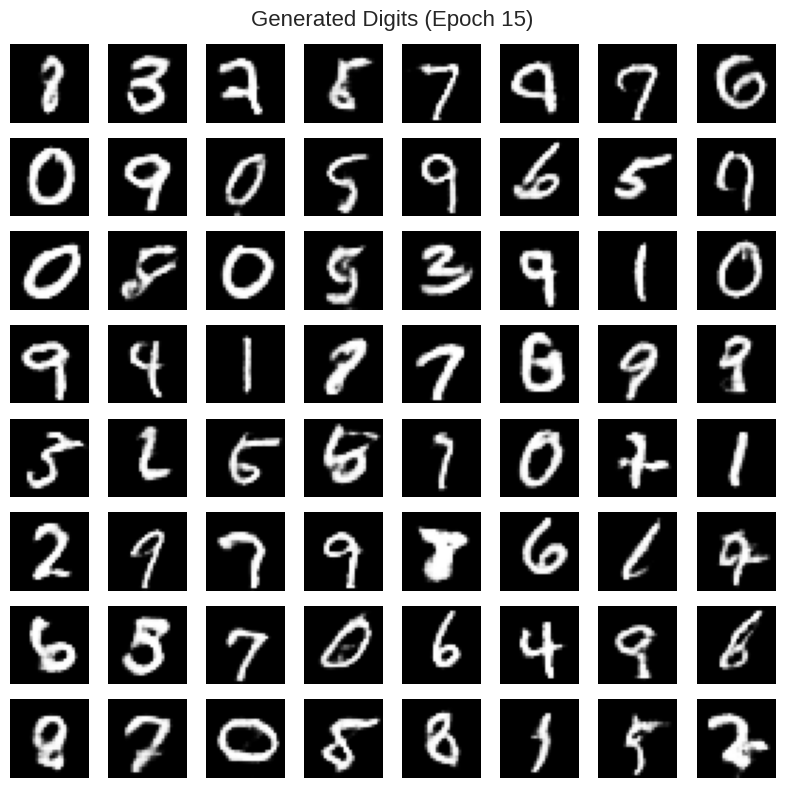

Epoch 16 | Batch    0 | Critic: -0.8372 | GP:  0.0032 | Gen: -4.9253
Epoch 16 | Batch  100 | Critic: -1.4587 | GP:  0.0072 | Gen: -2.9541
Epoch 16 | Batch  200 | Critic: -1.5876 | GP:  0.0135 | Gen: -4.9737
Epoch 16 | Batch  300 | Critic: -1.7384 | GP:  0.0072 | Gen:  0.9380
Epoch 16 | Batch  400 | Critic: -1.6367 | GP:  0.0094 | Gen: -2.5054
Epoch 16 | Batch  500 | Critic: -0.7960 | GP:  0.0065 | Gen: -3.1315
Epoch 16 | Batch  600 | Critic: -1.1538 | GP:  0.0110 | Gen: -3.5440
Epoch 16 | Batch  700 | Critic: -1.5283 | GP:  0.0046 | Gen: -4.3968
Epoch 16 | Batch  800 | Critic: -1.8278 | GP:  0.0068 | Gen: -2.2779
Epoch 16 | Batch  900 | Critic: -0.9446 | GP:  0.0035 | Gen: -2.7654
Epoch 17 | Batch    0 | Critic: -1.1801 | GP:  0.0060 | Gen: -4.0629
Epoch 17 | Batch  100 | Critic: -1.5321 | GP:  0.0054 | Gen: -5.6243
Epoch 17 | Batch  200 | Critic: -1.0366 | GP:  0.0104 | Gen:  1.7092
Epoch 17 | Batch  300 | Critic: -1.7637 | GP:  0.0216 | Gen: -6.3910
Epoch 17 | Batch  400 | Critic: -1

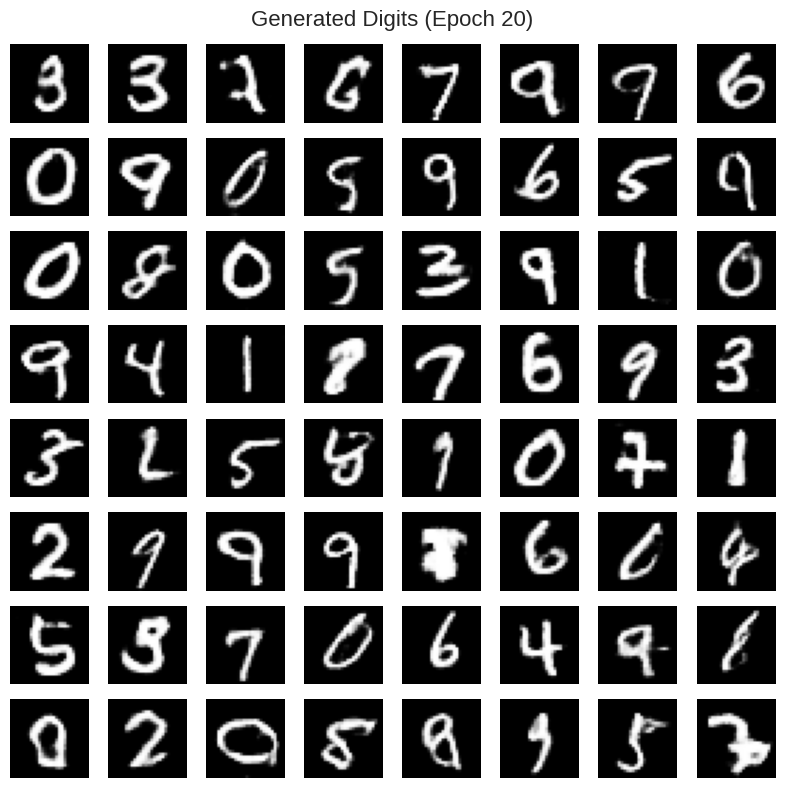

Epoch 21 | Batch    0 | Critic: -0.4544 | GP:  0.0060 | Gen: -4.7925
Epoch 21 | Batch  100 | Critic: -1.3589 | GP:  0.0035 | Gen: -5.3153
Epoch 21 | Batch  200 | Critic: -1.7094 | GP:  0.0115 | Gen: -3.6553
Epoch 21 | Batch  300 | Critic: -0.8839 | GP:  0.0075 | Gen:  0.2227
Epoch 21 | Batch  400 | Critic: -1.2933 | GP:  0.0041 | Gen: -0.1103
Epoch 21 | Batch  500 | Critic: -0.9736 | GP:  0.0034 | Gen: -3.7622
Epoch 21 | Batch  600 | Critic: -1.9750 | GP:  0.0222 | Gen:  3.0441
Epoch 21 | Batch  700 | Critic: -1.1959 | GP:  0.0040 | Gen: -0.8202
Epoch 21 | Batch  800 | Critic: -1.0604 | GP:  0.0041 | Gen: -4.2242
Epoch 21 | Batch  900 | Critic: -1.3686 | GP:  0.0069 | Gen: -4.5368
Epoch 22 | Batch    0 | Critic: -0.9343 | GP:  0.0096 | Gen: -5.7743
Epoch 22 | Batch  100 | Critic: -0.3349 | GP:  0.0045 | Gen: -3.6100
Epoch 22 | Batch  200 | Critic: -0.8886 | GP:  0.0062 | Gen: -2.2116
Epoch 22 | Batch  300 | Critic: -0.9436 | GP:  0.0051 | Gen:  0.5679
Epoch 22 | Batch  400 | Critic: -0

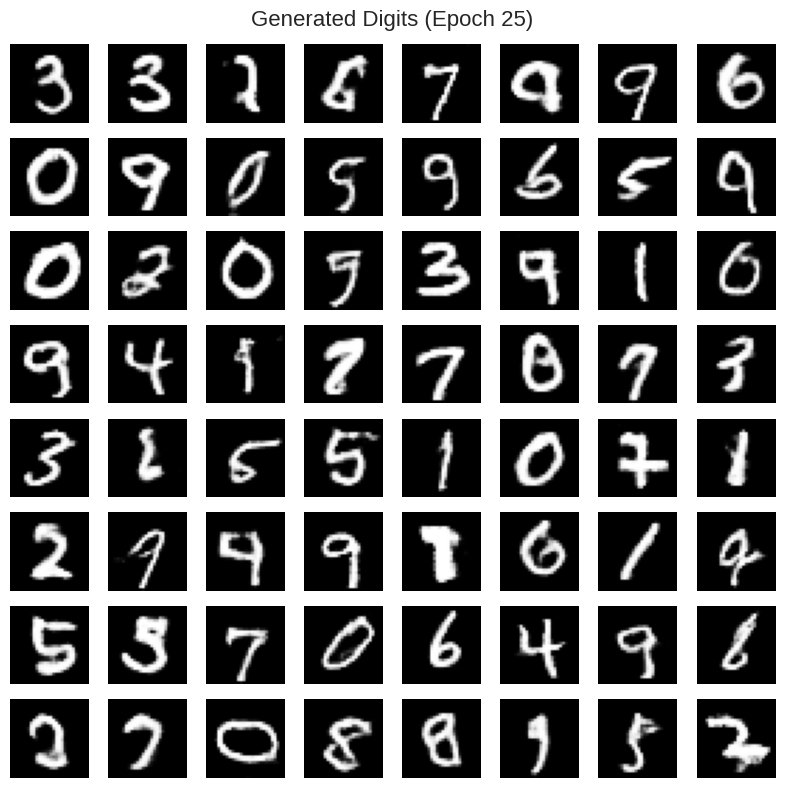

Epoch 26 | Batch    0 | Critic: -1.5307 | GP:  0.0196 | Gen: -6.9747
Epoch 26 | Batch  100 | Critic: -0.3665 | GP:  0.0049 | Gen:  1.6892
Epoch 26 | Batch  200 | Critic: -0.5310 | GP:  0.0041 | Gen: -3.6292
Epoch 26 | Batch  300 | Critic: -1.1164 | GP:  0.0210 | Gen: -5.7655
Epoch 26 | Batch  400 | Critic: -1.1417 | GP:  0.0077 | Gen: -3.1280
Epoch 26 | Batch  500 | Critic: -0.3683 | GP:  0.0068 | Gen:  0.5949
Epoch 26 | Batch  600 | Critic: -1.8496 | GP:  0.0048 | Gen: -0.9599
Epoch 26 | Batch  700 | Critic: -0.9341 | GP:  0.0034 | Gen: -5.7624
Epoch 26 | Batch  800 | Critic: -1.5003 | GP:  0.0053 | Gen:  2.5846
Epoch 26 | Batch  900 | Critic: -1.5666 | GP:  0.0091 | Gen:  1.0660
Epoch 27 | Batch    0 | Critic: -2.7932 | GP:  0.0210 | Gen: -3.9242
Epoch 27 | Batch  100 | Critic: -1.1735 | GP:  0.0044 | Gen: -0.8051
Epoch 27 | Batch  200 | Critic: -0.7005 | GP:  0.0040 | Gen: -3.1944
Epoch 27 | Batch  300 | Critic: -0.6281 | GP:  0.0168 | Gen: -3.0385
Epoch 27 | Batch  400 | Critic: -0

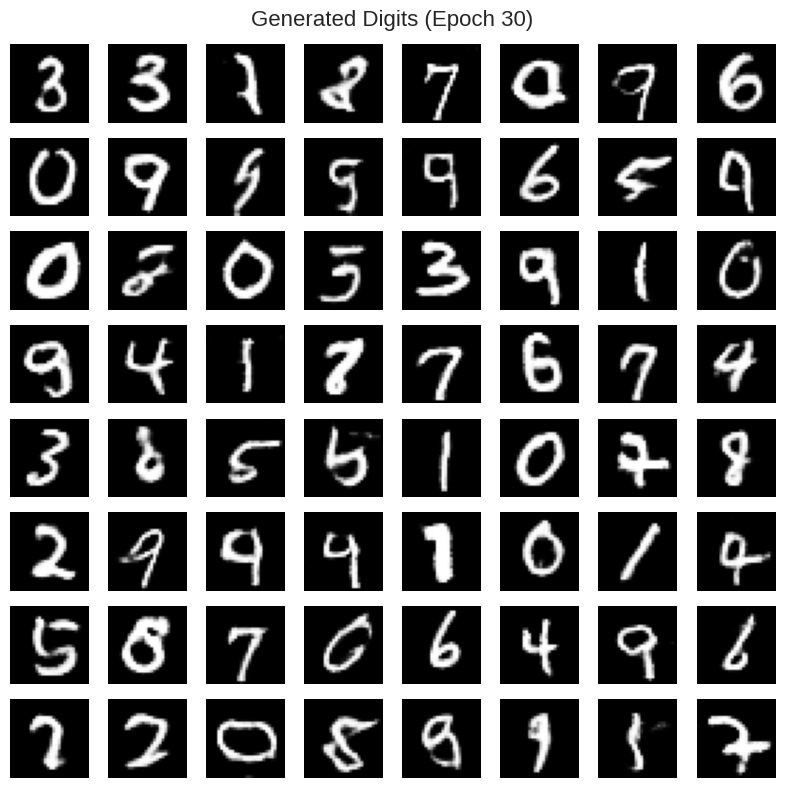

Epoch 31 | Batch    0 | Critic: -0.3557 | GP:  0.0119 | Gen: -6.1602
Epoch 31 | Batch  100 | Critic: -0.9027 | GP:  0.0075 | Gen: -4.3949
Epoch 31 | Batch  200 | Critic: -0.8977 | GP:  0.0048 | Gen:  2.3944
Epoch 31 | Batch  300 | Critic: -1.2533 | GP:  0.0049 | Gen: -4.6931
Epoch 31 | Batch  400 | Critic: -1.1117 | GP:  0.0050 | Gen:  1.4562
Epoch 31 | Batch  500 | Critic: -0.9118 | GP:  0.0036 | Gen: -4.9563
Epoch 31 | Batch  600 | Critic: -1.1644 | GP:  0.0044 | Gen:  0.3307
Epoch 31 | Batch  700 | Critic: -0.5609 | GP:  0.0051 | Gen: -3.8178
Epoch 31 | Batch  800 | Critic: -0.8905 | GP:  0.0057 | Gen: -1.9040
Epoch 31 | Batch  900 | Critic: -0.6025 | GP:  0.0021 | Gen: -4.7278
Epoch 32 | Batch    0 | Critic: -1.3317 | GP:  0.0070 | Gen: -3.1153
Epoch 32 | Batch  100 | Critic: -1.1837 | GP:  0.0058 | Gen: -2.6641
Epoch 32 | Batch  200 | Critic: -1.0892 | GP:  0.0064 | Gen: -3.8150
Epoch 32 | Batch  300 | Critic: -1.0487 | GP:  0.0087 | Gen:  3.6820
Epoch 32 | Batch  400 | Critic: -0

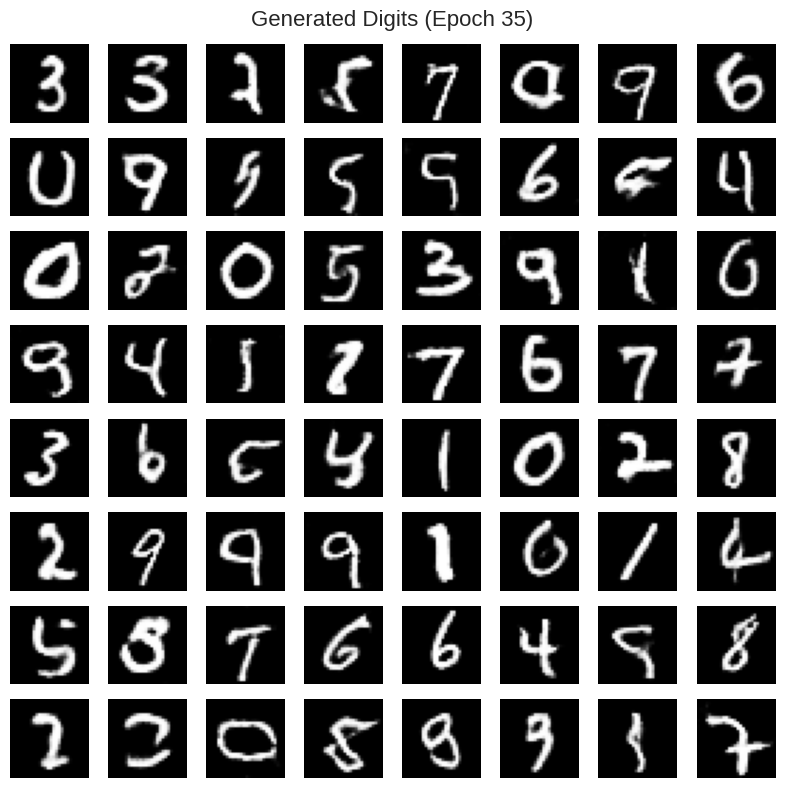

Epoch 36 | Batch    0 | Critic: -1.2242 | GP:  0.0085 | Gen: -4.5217
Epoch 36 | Batch  100 | Critic: -0.8096 | GP:  0.0084 | Gen: -1.9795
Epoch 36 | Batch  200 | Critic: -1.3190 | GP:  0.0063 | Gen:  1.8540
Epoch 36 | Batch  300 | Critic: -1.0095 | GP:  0.0071 | Gen: -3.5727
Epoch 36 | Batch  400 | Critic: -0.8667 | GP:  0.0063 | Gen: -3.6331
Epoch 36 | Batch  500 | Critic: -0.7952 | GP:  0.0029 | Gen: -3.5338
Epoch 36 | Batch  600 | Critic: -1.7631 | GP:  0.0020 | Gen: -1.4336
Epoch 36 | Batch  700 | Critic: -0.6694 | GP:  0.0023 | Gen: -2.7928
Epoch 36 | Batch  800 | Critic: -0.8763 | GP:  0.0431 | Gen: -2.9049
Epoch 36 | Batch  900 | Critic: -0.5873 | GP:  0.0031 | Gen: -1.6746
Epoch 37 | Batch    0 | Critic: -0.6863 | GP:  0.0029 | Gen: -3.9625
Epoch 37 | Batch  100 | Critic: -1.0343 | GP:  0.0101 | Gen:  1.0655
Epoch 37 | Batch  200 | Critic: -0.9953 | GP:  0.0035 | Gen: -5.6867
Epoch 37 | Batch  300 | Critic: -1.3467 | GP:  0.0040 | Gen: -0.7272
Epoch 37 | Batch  400 | Critic: -1

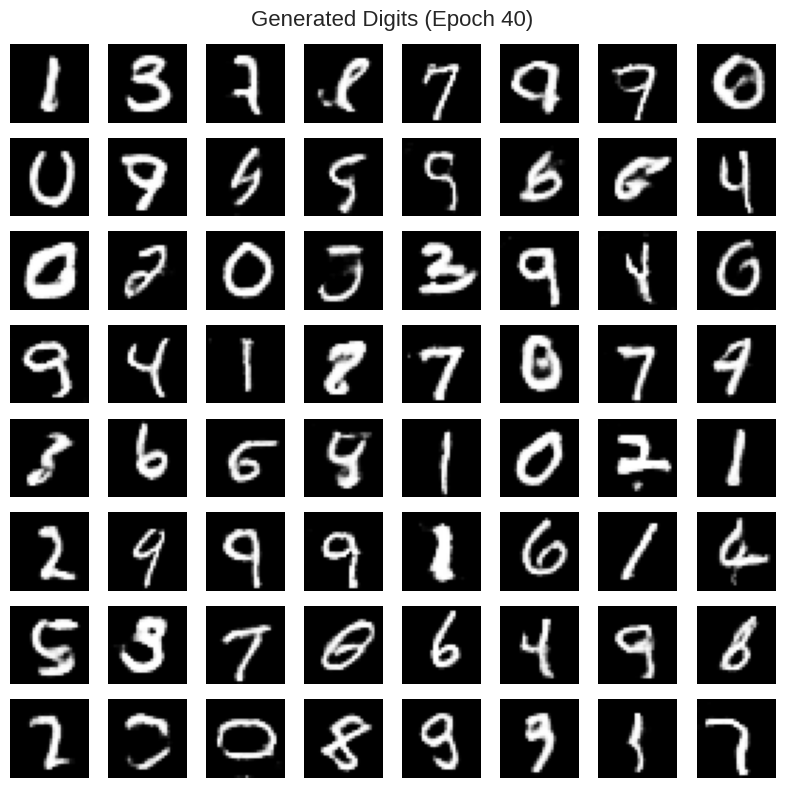

Epoch 41 | Batch    0 | Critic: -1.0506 | GP:  0.0029 | Gen: -1.8632
Epoch 41 | Batch  100 | Critic: -1.0459 | GP:  0.0061 | Gen: -5.7825
Epoch 41 | Batch  200 | Critic: -0.7715 | GP:  0.0045 | Gen: -4.8129
Epoch 41 | Batch  300 | Critic: -0.8436 | GP:  0.0028 | Gen: -0.1354
Epoch 41 | Batch  400 | Critic: -0.6545 | GP:  0.0033 | Gen: -0.5943
Epoch 41 | Batch  500 | Critic: -0.6054 | GP:  0.0109 | Gen: -2.2300
Epoch 41 | Batch  600 | Critic: -1.5910 | GP:  0.0089 | Gen:  1.5042
Epoch 41 | Batch  700 | Critic: -0.6078 | GP:  0.0059 | Gen: -2.0256
Epoch 41 | Batch  800 | Critic: -0.6276 | GP:  0.0080 | Gen: -0.9045
Epoch 41 | Batch  900 | Critic: -1.1629 | GP:  0.0036 | Gen: -3.3133
Epoch 42 | Batch    0 | Critic: -0.2344 | GP:  0.0045 | Gen: -6.8411
Epoch 42 | Batch  100 | Critic: -1.2397 | GP:  0.0056 | Gen:  3.9329
Epoch 42 | Batch  200 | Critic: -0.2332 | GP:  0.0021 | Gen: -3.0367
Epoch 42 | Batch  300 | Critic: -0.2097 | GP:  0.0037 | Gen: -4.1295
Epoch 42 | Batch  400 | Critic: -0

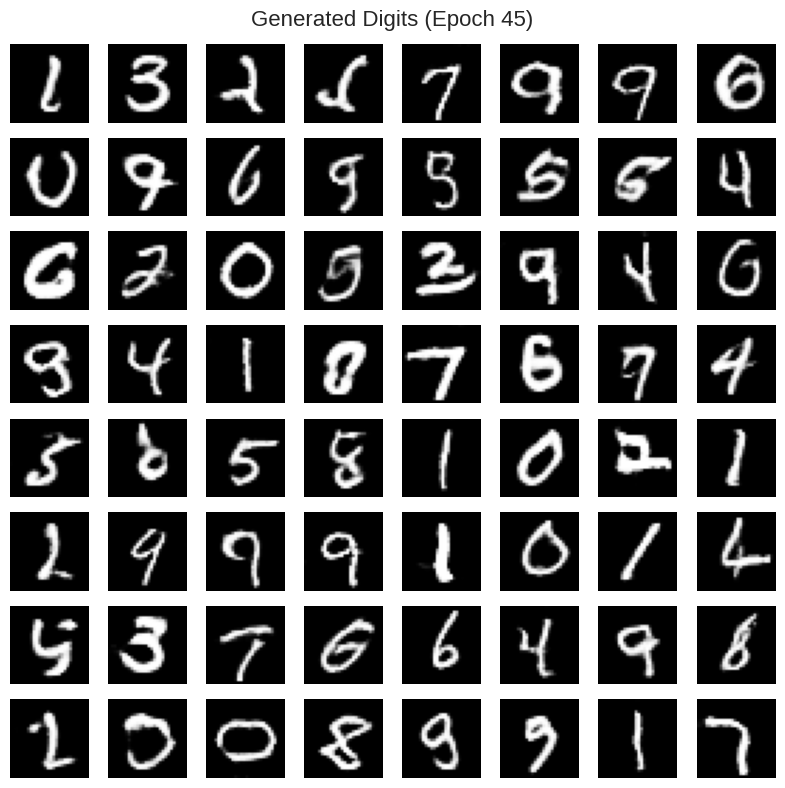

Epoch 46 | Batch    0 | Critic: -0.4893 | GP:  0.0026 | Gen: -0.8002
Epoch 46 | Batch  100 | Critic: -0.4883 | GP:  0.0049 | Gen: -3.0072
Epoch 46 | Batch  200 | Critic: -0.7571 | GP:  0.0022 | Gen: -4.7529
Epoch 46 | Batch  300 | Critic: -1.2857 | GP:  0.0053 | Gen: -7.2083
Epoch 46 | Batch  400 | Critic: -1.4161 | GP:  0.0030 | Gen: -6.4196
Epoch 46 | Batch  500 | Critic: -1.6457 | GP:  0.0050 | Gen: -0.7667
Epoch 46 | Batch  600 | Critic: -1.2583 | GP:  0.0108 | Gen: -7.0327
Epoch 46 | Batch  700 | Critic: -0.8511 | GP:  0.0077 | Gen:  3.4346
Epoch 46 | Batch  800 | Critic: -1.1097 | GP:  0.0037 | Gen:  2.2536
Epoch 46 | Batch  900 | Critic: -1.2976 | GP:  0.0040 | Gen: -6.8837
Epoch 47 | Batch    0 | Critic: -0.6375 | GP:  0.0053 | Gen: -1.5752
Epoch 47 | Batch  100 | Critic: -1.1035 | GP:  0.0050 | Gen: -5.9353
Epoch 47 | Batch  200 | Critic: -0.7761 | GP:  0.0032 | Gen: -7.2638
Epoch 47 | Batch  300 | Critic: -0.4343 | GP:  0.0030 | Gen: -8.4336
Epoch 47 | Batch  400 | Critic: -1

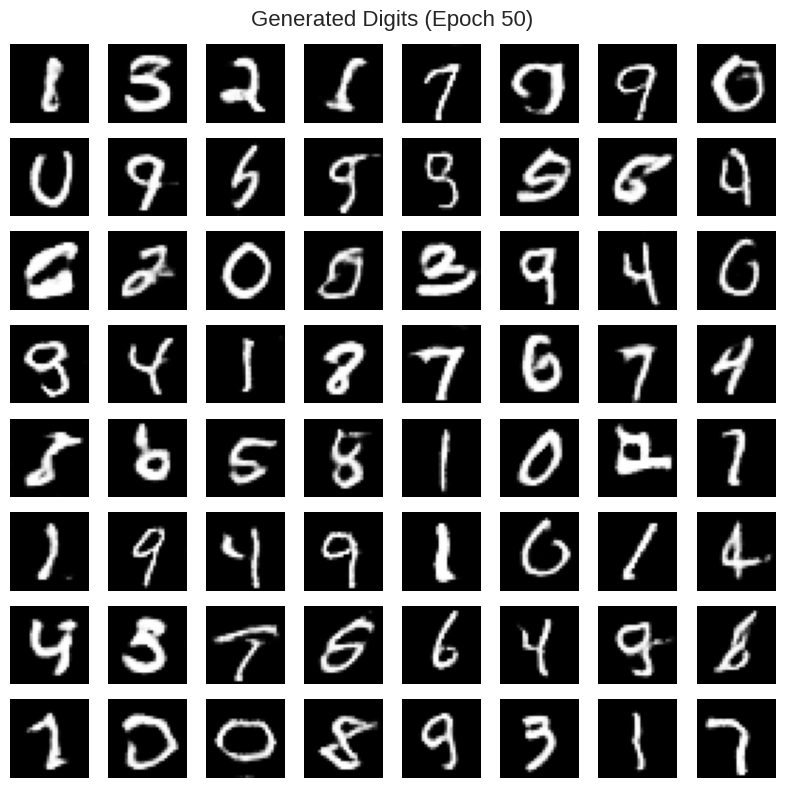

In [17]:
# Logging
critic_losses = []
gen_losses = []
gp_losses = []
steps = []

print("Starting WGAN-GP training on MNIST...")
for epoch in range(1, num_epochs + 1):

    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)  # (B, 1, 28, 28)

        # --- Train Critic (n_critic times) ---
        for _ in range(n_critic):
            # Generate fakes
            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = gen(z).detach()

            # Critic scores
            critic_real = critic(real_images)
            critic_fake = critic(fake_images)

            # W-loss
            w_loss = critic_fake.mean() - critic_real.mean()

            # GP
            gp = compute_gradient_penalty(critic, real_images, fake_images, device)

            # Total critic loss
            critic_loss = w_loss + lambda_gp * gp

            # Backprop
            opt_critic.zero_grad()
            critic_loss.backward()
            opt_critic.step()

        # --- Train Generator ---
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_images = gen(z)
        critic_fake = critic(fake_images)
        gen_loss = -critic_fake.mean()

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        # Log every 100 batches
        if i % 100 == 0:
            critic_losses.append(critic_loss.item())
            gen_losses.append(gen_loss.item())
            gp_losses.append(gp.item())
            steps.append(epoch + i / len(dataloader))
            print(f"Epoch {epoch:2d} | Batch {i:4d} | "
                  f"Critic: {critic_loss.item(): .4f} | "
                  f"GP: {gp.item(): .4f} | "
                  f"Gen: {gen_loss.item(): .4f}")

    # --- End of Epoch: Save samples ---
    if epoch % 5 == 0 or epoch == 1:
        with torch.no_grad():
            fake = gen(fixed_z).cpu()
        # Denormalize: [-1,1] → [0,1]
        fake = (fake + 1) / 2
        # Plot 8×8 grid
        fig, ax = plt.subplots(8, 8, figsize=(8, 8))
        for idx, a in enumerate(ax.flatten()):
            a.imshow(fake[idx, 0], cmap='gray')
            a.axis('off')
        plt.suptitle(f'Generated Digits (Epoch {epoch})', fontsize=16)
        plt.tight_layout()
        plt.show()

**Final Training Curves**

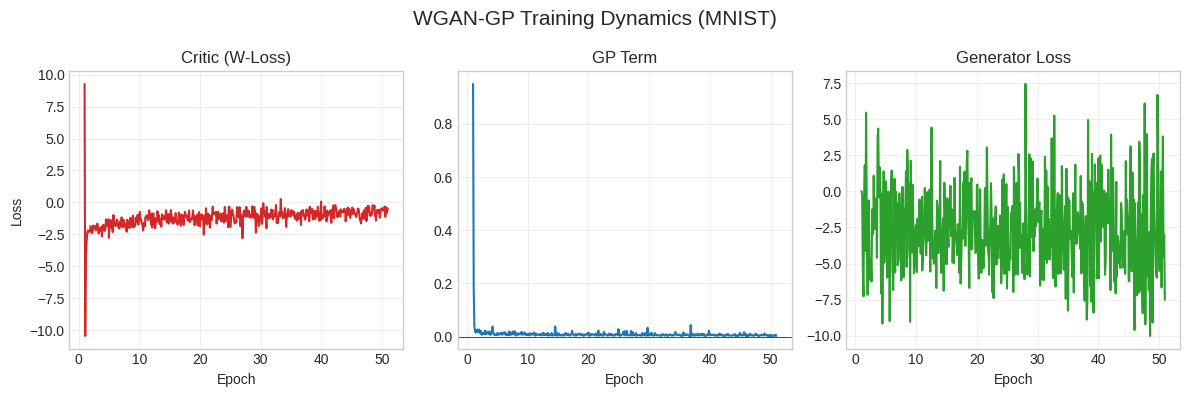

In [18]:
# Plot losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(steps, critic_losses, label='Critic Loss', color='tab:red')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Critic (W-Loss)'); plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(steps, gp_losses, label='Gradient Penalty', color='tab:blue')
plt.axhline(0, color='k', lw=0.5); plt.xlabel('Epoch'); plt.title('GP Term'); plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(steps, gen_losses, label='Generator Loss', color='tab:green')
plt.xlabel('Epoch'); plt.title('Generator Loss'); plt.grid(True, alpha=0.3)

plt.suptitle('WGAN-GP Training Dynamics (MNIST)', fontsize=15)
plt.tight_layout()
plt.show()